# Reading housing.csv file

In [1]:
import pandas as pd
import numpy as np

In [2]:
from arcgis.gis import GIS
gis = GIS("https://deldev.maps.arcgis.com", "demos_deldev", "DelDevs12")

In [3]:
item = gis.content.search('housing')[0]

In [4]:
housing = item.layers[0]

In [5]:
sedf = pd.DataFrame.spatial.from_layer(housing)

In [6]:
sedf.head()

,ObjectId,SHAPE,households,housing_median_age,latitude,longitude,median_house_value,median_income,ocean_proximity,population,total_bedrooms,total_rooms
0,400,"{""x"": -13606581.359661829, ""y"": 4551210.919691...",415.0,50.0,37.80,-122.23,123500.0,2.2500,NEAR BAY,1149.0,480.0,1746.0
1,401,"{""x"": -13606581.359661829, ""y"": 4551210.919691...",280.0,52.0,37.80,-122.23,111900.0,2.3929,NEAR BAY,844.0,299.0,1252.0
2,402,"{""x"": -13606581.359661829, ""y"": 4549802.184000...",1231.0,43.0,37.79,-122.23,112800.0,2.1917,NEAR BAY,4367.0,1344.0,5963.0
3,403,"{""x"": -13606581.359661829, ""y"": 4549802.184000...",412.0,52.0,37.79,-122.23,107900.0,2.9357,NEAR BAY,1659.0,395.0,1783.0
4,404,"{""x"": -13606581.359661829, ""y"": 4549802.184000...",263.0,30.0,37.79,-122.23,137500.0,1.8854,NEAR BAY,1011.0,264.0,999.0


In [7]:
sedf.shape

(20640, 12)

In [8]:
sedf.loc[:,'median_income'] *= 10000

# Creating train and test set

In [9]:
from sklearn.model_selection import train_test_split

# stratified sampling

In [10]:
# Divide by 1.5 to limit the number of income categories
sedf["income_cat"] = np.ceil(sedf["median_income"] / 1.5)
# Label those above 5 as 5
sedf["income_cat"].where(sedf["income_cat"] < 5, 5.0, inplace=True)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(sedf, sedf["income_cat"]):
    train_set = sedf.loc[train_index]
    test_set = sedf.loc[test_index]

In [12]:
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Looking for correlations among attributes

In [13]:
corr_matrix = train_set.corr()


In [14]:
corr_matrix['median_house_value'].sort_values()

latitude             -0.141589
longitude            -0.049743
population           -0.026638
total_bedrooms        0.046955
households            0.064044
ObjectId              0.082526
housing_median_age    0.107168
total_rooms           0.129773
median_income         0.685203
median_house_value    1.000000
Name: median_house_value, dtype: float64

The correlation ranges from -1 to 1.This shows that median_house_value has a strong correlation with median_income, total rooms, and housing_median_age.We however need to know the nmer of rooms per houehold since the total_rooms information is complete unless otherwise.Moreover t_otal_bedrooms have a positive correlation with the median_house_value so it is important to know the number of bedroom per total_room.Populaton of a disrrict affects the housing valueIn soe areas more population leds to decrease in th housing prices..We will fnd out the population per household.

# Adding attributes

In [15]:
train_set['room_per_household'] = train_set['total_rooms'] / train_set['households']

In [16]:
train_set['bedrooms_total_room'] = train_set['total_bedrooms'] / train_set['total_rooms']

In [17]:
train_set['population_per_household'] = train_set['population'] / train_set['households']

In [18]:
train_set['bedroom_per_households'] = train_set['total_bedrooms'] / train_set['households']

In [19]:
train_set.head()

,ObjectId,SHAPE,households,housing_median_age,latitude,longitude,median_house_value,median_income,ocean_proximity,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households
11604,11605,"{""x"": -13132360.328882482, ""y"": 3996621.235835...",369.0,18.0,33.76,-117.97,194000.0,31771.0,<1H OCEAN,1301.0,399.0,1862.0,5.046070,0.214286,3.525745,1.081301
10897,10898,"{""x"": -13125681.159434887, ""y"": 3980564.649116...",326.0,29.0,33.64,-117.91,325400.0,48098.0,<1H OCEAN,832.0,310.0,1652.0,5.067485,0.187651,2.552147,0.950920
12076,12077,"{""x"": -13036625.566800267, ""y"": 4026116.830822...",301.0,25.0,33.98,-117.11,149000.0,27344.0,INLAND,715.0,312.0,1254.0,4.166113,0.248804,2.375415,1.036545
13277,13278,"{""x"": -12956475.533429112, ""y"": 4048961.188708...",964.0,15.0,34.15,-116.39,73300.0,19779.0,INLAND,2709.0,1149.0,5583.0,5.791494,0.205803,2.810166,1.191909
308,38,"{""x"": -13611034.139293559, ""y"": 4558257.460986...",303.0,52.0,37.85,-122.27,155500.0,21202.0,NEAR BAY,648.0,293.0,1228.0,4.052805,0.238599,2.138614,0.966997


# Rechecking the correlation

In [20]:
corr_matrix = train_set.corr()

corr_matrix['median_house_value'].sort_values()

bedrooms_total_room        -0.234396
latitude                   -0.141589
bedroom_per_households     -0.059058
longitude                  -0.049743
population                 -0.026638
population_per_household   -0.022174
total_bedrooms              0.046955
households                  0.064044
ObjectId                    0.082526
housing_median_age          0.107168
total_rooms                 0.129773
room_per_household          0.149208
median_income               0.685203
median_house_value          1.000000
Name: median_house_value, dtype: float64

In [21]:
train_set.columns

Index(['ObjectId', 'SHAPE', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_house_value', 'median_income', 'ocean_proximity',
       'population', 'total_bedrooms', 'total_rooms', 'room_per_household',
       'bedrooms_total_room', 'population_per_household',
       'bedroom_per_households'],
      dtype='object')

In [22]:
train_set.dtypes

ObjectId                       int64
SHAPE                       geometry
households                   float64
housing_median_age           float64
latitude                     float64
longitude                    float64
median_house_value           float64
median_income                float64
ocean_proximity               object
population                   float64
total_bedrooms               float64
total_rooms                  float64
room_per_household           float64
bedrooms_total_room          float64
population_per_household     float64
bedroom_per_households       float64
dtype: object

In [23]:
y_tr = train_set['median_house_value']

In [24]:
train_set.drop('median_house_value', inplace=True, axis=1)

# Replacng Nan values with the median

In [25]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [26]:
train_set_num = train_set.drop(['ocean_proximity','SHAPE'], axis=1)

In [27]:
imputer.fit(train_set_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [28]:
train_set_num.median().values

array([ 1.02605000e+04,  4.10000000e+02,  2.90000000e+01,  3.42500000e+01,
       -1.18490000e+02,  3.53130000e+04,  1.16700000e+03,  4.32000000e+02,
        2.12350000e+03,  5.22488366e+00,  2.02942604e-01,  2.82017903e+00,
        1.04798918e+00])

In [29]:
X = imputer.transform(train_set_num)

In [30]:
X.shape

(16512, 13)

In [31]:
x_train = pd.DataFrame(X, columns=train_set_num.columns,
                          index = list(train_set.index.values))

# Merging the numerical and categoricaldateset

In [32]:
train_xtr = pd.concat([x_train, train_set['ocean_proximity']], axis=1)

In [33]:
train_xtr.head()

,ObjectId,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households,ocean_proximity
11604,11605.0,369.0,18.0,33.76,-117.97,31771.0,1301.0,399.0,1862.0,5.046070,0.214286,3.525745,1.081301,<1H OCEAN
10897,10898.0,326.0,29.0,33.64,-117.91,48098.0,832.0,310.0,1652.0,5.067485,0.187651,2.552147,0.950920,<1H OCEAN
12076,12077.0,301.0,25.0,33.98,-117.11,27344.0,715.0,312.0,1254.0,4.166113,0.248804,2.375415,1.036545,INLAND
13277,13278.0,964.0,15.0,34.15,-116.39,19779.0,2709.0,1149.0,5583.0,5.791494,0.205803,2.810166,1.191909,INLAND
308,38.0,303.0,52.0,37.85,-122.27,21202.0,648.0,293.0,1228.0,4.052805,0.238599,2.138614,0.966997,NEAR BAY


In [34]:
train_xtr.columns

Index(['ObjectId', 'households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'population', 'total_bedrooms', 'total_rooms',
       'room_per_household', 'bedrooms_total_room', 'population_per_household',
       'bedroom_per_households', 'ocean_proximity'],
      dtype='object')

# Converting categorical attribute to int type

In [35]:
x_tr = pd.get_dummies(train_xtr)

In [36]:
x_tr.head()

,ObjectId,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
11604,11605.0,369.0,18.0,33.76,-117.97,31771.0,1301.0,399.0,1862.0,5.046070,0.214286,3.525745,1.081301,1,0,0,0,0
10897,10898.0,326.0,29.0,33.64,-117.91,48098.0,832.0,310.0,1652.0,5.067485,0.187651,2.552147,0.950920,1,0,0,0,0
12076,12077.0,301.0,25.0,33.98,-117.11,27344.0,715.0,312.0,1254.0,4.166113,0.248804,2.375415,1.036545,0,1,0,0,0
13277,13278.0,964.0,15.0,34.15,-116.39,19779.0,2709.0,1149.0,5583.0,5.791494,0.205803,2.810166,1.191909,0,1,0,0,0
308,38.0,303.0,52.0,37.85,-122.27,21202.0,648.0,293.0,1228.0,4.052805,0.238599,2.138614,0.966997,0,0,0,1,0


# Feature scaling

In [37]:
train_scaled = (x_tr-x_tr.min())/(x_tr.max()-x_tr.min())

In [38]:
train_scaled.head()

,ObjectId,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
11604,0.562264,0.060516,0.333333,0.129649,0.635458,0.184632,0.045276,0.061908,0.047210,0.031893,0.214286,0.002280,0.031741,1.0,0.0,0.0,0.0,0.0
10897,0.528007,0.053445,0.549020,0.116897,0.641434,0.297230,0.028854,0.048099,0.041868,0.032056,0.187651,0.001497,0.027914,1.0,0.0,0.0,0.0,0.0
12076,0.585134,0.049334,0.470588,0.153029,0.721116,0.154101,0.024757,0.048410,0.031744,0.025211,0.248804,0.001354,0.030427,0.0,1.0,0.0,0.0,0.0
13277,0.643328,0.158362,0.274510,0.171095,0.792829,0.101930,0.094579,0.178278,0.141858,0.037554,0.205803,0.001704,0.034988,0.0,1.0,0.0,0.0,0.0
308,0.001793,0.049663,1.000000,0.564293,0.207171,0.111743,0.022411,0.045462,0.031083,0.024351,0.238599,0.001164,0.028385,0.0,0.0,0.0,1.0,0.0


In [39]:
train_scaled.columns

Index(['ObjectId', 'households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'population', 'total_bedrooms', 'total_rooms',
       'room_per_household', 'bedrooms_total_room', 'population_per_household',
       'bedroom_per_households', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

# Training a model

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_scaled, y_tr)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_scaled, y_tr)))



Accuracy of K-NN classifier on training set: 0.21


In [41]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5).fit(train_scaled, y_tr)


In [42]:
dt.score(train_scaled, y_tr)

0.050387596899224806

In [43]:
from sklearn.linear_model import LinearRegression 

linreg = LinearRegression().fit(train_scaled, y_tr)

print('linear model intercept: {}'
     .format(linreg.intercept_))
print('linear model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(train_scaled, y_tr)))


linear model intercept: 179507.1690846124
linear model coeff:
[   20302.37854785   918826.89423066    58003.13370355  -239780.52544535
  -264897.02469591   556748.98496459 -1354491.85239168  -110515.3071634
   130830.683349    1356548.80585299   364219.65580957   182855.84424267
 -1206732.91059404   -19997.34160947   -58392.23752055   119141.20069784
   -21290.92566289   -19460.69590493]
R-squared score (training): 0.657


In [44]:
from sklearn.metrics import mean_squared_error

prediction = linreg.predict(train_scaled)
lin_mse = mean_squared_error(y_tr, prediction)
lin_rmse = np.sqrt(lin_mse)

In [45]:
lin_rmse

67733.89442324606

In [46]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(train_scaled, y_tr)
print('R-squared score (training): {:.3f}'
     .format(linridge.score(train_scaled, y_tr)))

R-squared score (training): 0.625


In [47]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest = forest_reg.fit(train_scaled, y_tr)

prediction_ = forest.predict(train_scaled)
forest_mse = mean_squared_error(y_tr, prediction_)
forest_rmse = np.sqrt(forest_mse)

In [48]:
forest_rmse

21922.36111537805

In [49]:
forest.score(train_scaled, y_tr)

0.9640233887112226

# fine tuning

In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg, train_scaled, y_tr,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [51]:
tree_rmse_scores

array([49198.95540545, 52257.62684781, 49852.46112037, 52606.98886112,
       49723.07884221, 51931.71968278, 51292.97537445, 53973.24528959,
       52998.01202135, 53815.63869503])

In [52]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_scaled, y_tr)
housing_predictions = svm_reg.predict(train_scaled)
svm_mse = mean_squared_error(y_tr, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

117721.0398281578

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]


grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_scaled, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [54]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

# Cleaning test set

In [55]:
test_set['room_per_household'] = test_set['total_rooms'] / test_set['households']

In [56]:
test_set['bedrooms_total_room'] = test_set['total_bedrooms'] / test_set['total_rooms']

In [57]:
test_set['population_per_household'] = test_set['population'] / test_set['households']

In [58]:
test_set['bedroom_per_households'] = test_set['total_bedrooms'] / test_set['households']

In [59]:
y_ts = test_set['median_house_value']

In [60]:
test_set.drop('median_house_value', inplace=True, axis=1)

In [61]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [62]:
test_set_num = test_set.drop(['ocean_proximity', 'SHAPE'], axis=1)

In [63]:
imputer.fit(test_set_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [64]:
X = imputer.transform(test_set_num)

In [65]:
x_test = pd.DataFrame(X, columns=test_set_num.columns,
                          index = list(test_set.index.values))

In [66]:
x_test.head()

,ObjectId,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households
488,489.0,340.0,32.0,37.68,-122.05,61104.0,1019.0,318.0,2015.0,5.926471,0.157816,2.997059,0.935294
6644,6645.0,266.0,34.0,34.09,-117.90,41250.0,825.0,272.0,1562.0,5.872180,0.174136,3.101504,1.022556
7812,7813.0,387.0,43.0,33.92,-118.17,31528.0,1276.0,398.0,2099.0,5.423773,0.189614,3.297158,1.028424
19390,19391.0,287.0,42.0,37.61,-121.09,38864.0,921.0,296.0,1787.0,6.226481,0.165641,3.209059,1.031359
2665,2666.0,399.0,19.0,37.39,-118.60,32132.0,1134.0,518.0,2682.0,6.721805,0.193139,2.842105,1.298246


In [67]:
test_x = pd.concat([x_test, test_set['ocean_proximity']], axis=1)

In [68]:
x_ts = pd.get_dummies(test_x)

In [69]:
x_ts.columns

Index(['ObjectId', 'households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'population', 'total_bedrooms', 'total_rooms',
       'room_per_household', 'bedrooms_total_room', 'population_per_household',
       'bedroom_per_households', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [70]:
x_ts.head()

,ObjectId,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,room_per_household,bedrooms_total_room,population_per_household,bedroom_per_households,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
488,489.0,340.0,32.0,37.68,-122.05,61104.0,1019.0,318.0,2015.0,5.926471,0.157816,2.997059,0.935294,0,0,0,1,0
6644,6645.0,266.0,34.0,34.09,-117.90,41250.0,825.0,272.0,1562.0,5.872180,0.174136,3.101504,1.022556,1,0,0,0,0
7812,7813.0,387.0,43.0,33.92,-118.17,31528.0,1276.0,398.0,2099.0,5.423773,0.189614,3.297158,1.028424,1,0,0,0,0
19390,19391.0,287.0,42.0,37.61,-121.09,38864.0,921.0,296.0,1787.0,6.226481,0.165641,3.209059,1.031359,0,1,0,0,0
2665,2666.0,399.0,19.0,37.39,-118.60,32132.0,1134.0,518.0,2682.0,6.721805,0.193139,2.842105,1.298246,0,1,0,0,0


In [71]:
test_scaled = (x_ts-x_ts.min())/(x_ts.max()-x_ts.min())

In [72]:
test_scaled.shape

(4128, 18)

# Testing the model on the test set

In [73]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

prediction_ = forest.predict(test_scaled)
forest_mse = mean_squared_error(y_ts, prediction_)
forest_rmse = np.sqrt(forest_mse)

In [74]:
forest_rmse

75399.00341991468

In [75]:
forest.score(test_scaled, y_ts)

0.5674688148742995

In [76]:
train_scaled.shape, y_tr.shape

((16512, 18), (16512,))

In [77]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest = forest_reg.fit(train_scaled, y_tr)

prediction_ = forest.predict(test_scaled)
forest_mse = mean_squared_error(y_ts, prediction_)
forest_rmse = np.sqrt(forest_mse)

In [78]:
forest_rmse

72512.13677484289

In [79]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = [10], alpha = 5,
                       random_state = 0, solver='lbfgs', verbose=0)

clf_ = clf.fit(train_scaled, y_tr)

In [82]:
clf_.predict(test_scaled)

array([500001., 500001., 500001., ..., 162500.,  87500., 116300.])

In [83]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_scaled)

final_mse = mean_squared_error(y_ts, final_predictions)
final_rmse = np.sqrt(final_mse)

In [84]:
final_rmse

67647.45918590928

# visualizations

In [85]:
import seaborn as sns

In [86]:
df = sedf[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']]

In [90]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.80,50.0,1746.0,480.0,1149.0,415.0,22500.0,123500.0
1,-122.23,37.80,52.0,1252.0,299.0,844.0,280.0,23929.0,111900.0
2,-122.23,37.79,43.0,5963.0,1344.0,4367.0,1231.0,21917.0,112800.0
3,-122.23,37.79,52.0,1783.0,395.0,1659.0,412.0,29357.0,107900.0
4,-122.23,37.79,30.0,999.0,264.0,1011.0,263.0,18854.0,137500.0


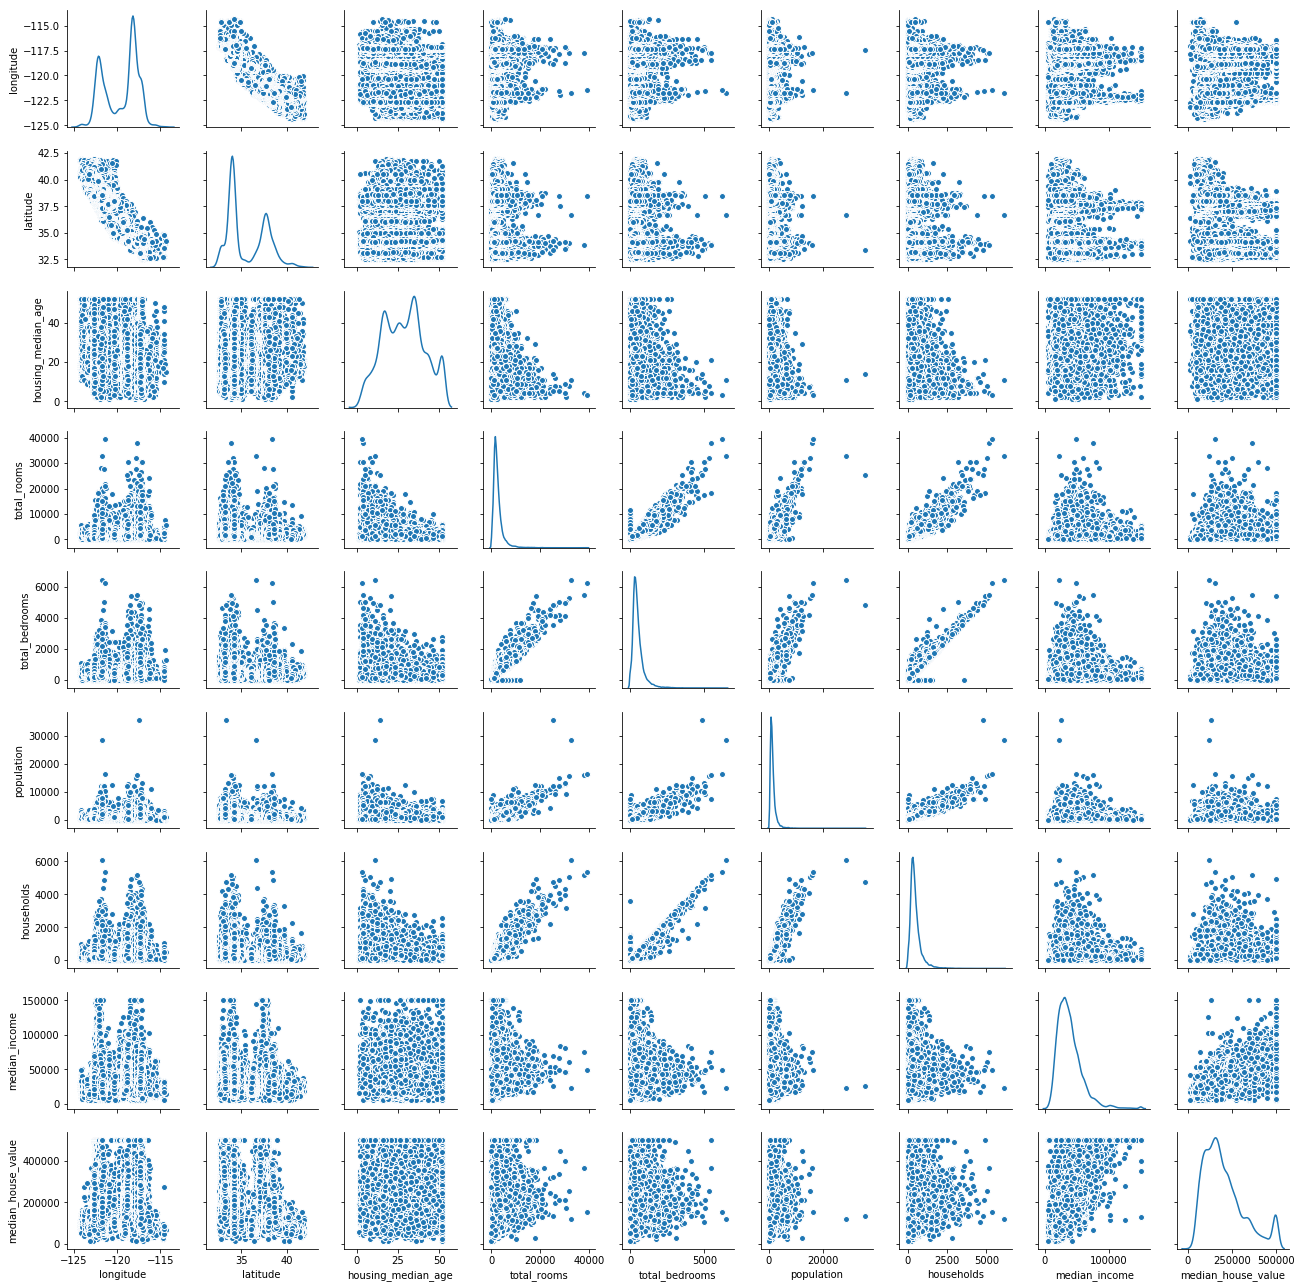

In [91]:
sns.pairplot(df, diag_kind="kde", size=2)

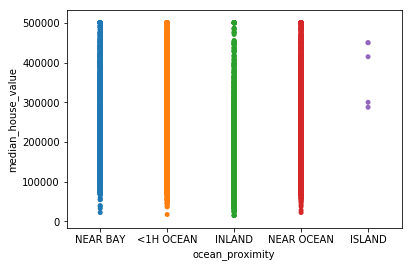

In [96]:
sns.stripplot(x=sedf.ocean_proximity, y=sedf.median_house_value, data=sedf);

In [93]:
cf = df[['median_income', 'median_house_value']]

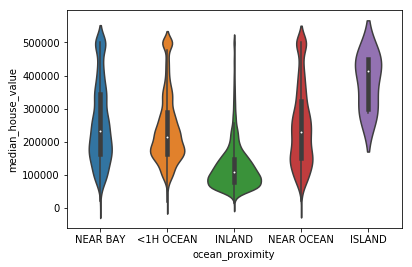

In [95]:
sns.violinplot(x=sedf.ocean_proximity, y=sedf.median_house_value, data=sedf);

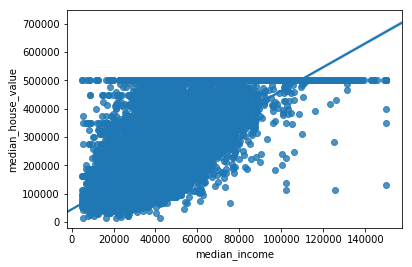

In [97]:
sns.regplot(x=sedf.median_income, y=sedf.median_house_value, data=sedf);

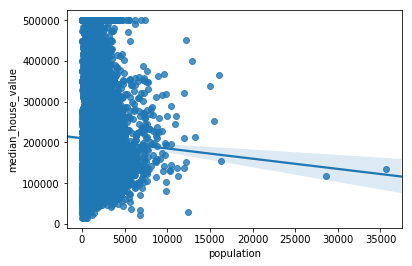

In [98]:
sns.regplot(x=sedf.population, y=sedf.median_house_value, data=sedf);

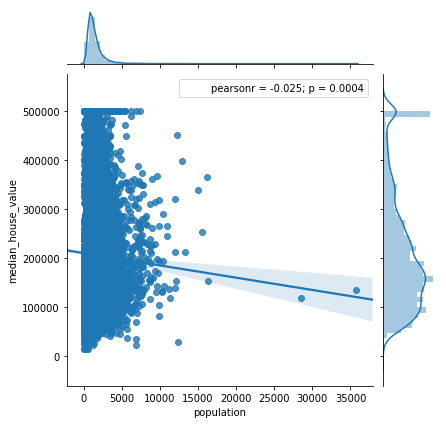

In [99]:
sns.jointplot(x=sedf.population, y=sedf.median_house_value, data=sedf, kind="reg");

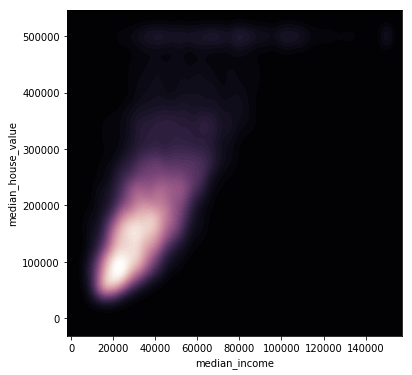

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(sedf.median_income, sedf.median_house_value, cmap=cmap, n_levels=60, shade=True);

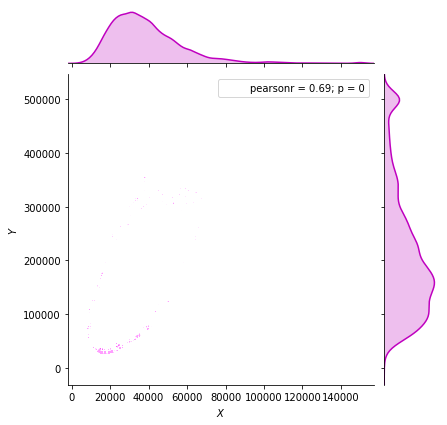

In [102]:
g = sns.jointplot(x=sedf.median_income, y=sedf.median_house_value, data=sedf, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

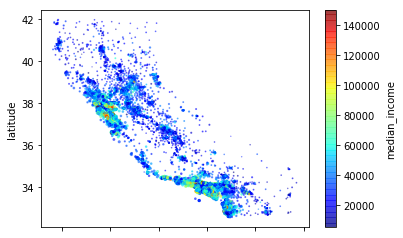

In [104]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=sedf["median_house_value"]/100000,c="median_income", cmap=plt.get_cmap("jet"))